## Worksheet 7

### Group 22 Eaton Heidegger and Shannon Schröder

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from numba import stencil, njit
import time
import sympy as sp

### Poisson equation
### N-body gravity solver

#### a) 

Greens function approach: 

If you have a linear differential equation of the form:
$L u(x) = f(x)$

where:

- $L$ is a linear differential operator (like the Laplacian $\nabla^2$ or a time derivative),
- $u(x)$ is the unknown function,
- $f(x)$ is a known source function,

then the Green’s function $G(x, x')$ is the solution to:

$L G(x, x') = \delta(x - x')$

where $\delta(x - x')$ is the Dirac delta function, representing a point source at position x'. 

The solutuion u(x) is gien by: 


$ u(x): \int G(x,x')f(x') dx'$ 


But first, we use the Plumber sampler from the provided notebook to sample the positions of N=1000 stars from a Plummer sphere using inverse transform sampling and random isotropic directions.

(-10.0, 10.0)

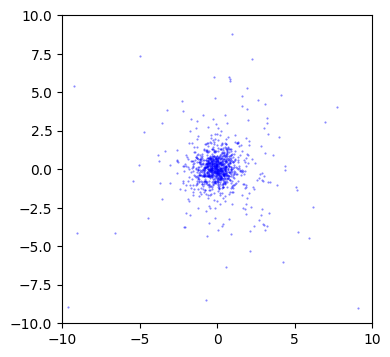

In [2]:
# Sample Plumber from provided Notebook :

# initialise the random number generator
rng = np.random.Generator(np.random.PCG64(seed=12345))

# Sample isotropic 3d vectors with a given modulus
def rand_vec3d( mod ):
    N = len(mod)
    phi = 2*np.pi*rng.random(size=N)
    theta = np.arccos( 2*rng.random(size=N)-1 )
    v3d = np.zeros( (N,3) )
    v3d[:,0] = mod * np.cos( phi ) * np.sin( theta )
    v3d[:,1] = mod * np.sin( phi ) * np.sin( theta )
    v3d[:,2] = mod * np.cos( theta )
    # subtract mean
    for i in range(3):
        v3d[:,i] -= np.mean(v3d[:,i])
    return v3d

# number of stars
N = 1000

# particle mass is 1/N
m = 1/N

# Sampling the mass, draw radii through inversion sampling from the cumulative mass M
U = rng.random(size=N)
rsamp = U**(1/3)/np.sqrt((1-U**(2/3)))

# create N empty 3D vectors
x3d = rand_vec3d( rsamp )
positions = x3d
# make a scatter plot of the stars
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(x3d[:,0], x3d[:,1], marker='.', s=1, c='b', alpha=0.5)
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

Now we compute the 3D potential numerically via Green's function

The gravitational potential $\Phi(r)$ at a point $\vec{r}$ is: 

$\Phi(r) = - G \sum_{j \neq i}^N \frac{Gm}{|r_i - r_j|}$

In N body units: G = 1, m = 1/N (used WS 5)

The Green's functiton for gravitational potential is: 

$\Phi(r) = - \frac{1}{N} \sum_{j \neq i}^N \frac{1}{|r_i - r_j| + \epsilon^2}$

This is the numerical potential at position $r_i$, due to all other particles, softened with $\epsilon$ (which could be set to zero or a small value to avoid singularities). Because we exclude i = j to avoid singularities we can set $\epsilon$ to 0.


For the accelertion: $a(x) = - (\nabla \Phi)(x)$ (important for b) later on): 

$\vec{a}_j = - \nabla \Phi_j =- \frac{1}{N} \sum_{j \neq i}^N \frac{r_j-r_i}{|r_i - r_j|^3} $

In [7]:
def compute_potential(positions):
    """
    Compute the gravitational potential and acceleration for a system of N particles
    using the Green's function approach in N-body units (G = 1, M = 1, m = 1/N).

    Parameters
    ----------
    positions : ndarray
        Array of shape (N, 3) containing 3D positions of the particles.

    Returns
    -------
    phi : ndarray
        Gravitational potential at each particle position (N,).
    acc : ndarray
        Acceleration vectors for each particle (N, 3).
    """
    N = positions.shape[0]
    m = 1/N

    # Compute pairwise position differences: shape (N, N, 3)
    dx = positions[:, np.newaxis, :] - positions[np.newaxis, :, :]  # r_i - r_j

    # Compute pairwise distances: shape (N, N)
    r = np.linalg.norm(dx, axis=2)

    # Avoid division by zero for self-interaction by setting diagonals to inf
    np.fill_diagonal(r, np.inf)
    # Distance matrix (NxN)
    #r_ij = cdist(x3d, x3d)
    # Potential: φ_j = -m * sum_i≠j 1/|r_j - r_i|
    phi = -1/N * np.sum(1 / r, axis=1)
    # Acceleration: a_j = -m * sum_i≠j (r_j - r_i) / |r_j - r_i|^3
    r3 = r**3
    acc = -m * np.sum(dx / r3[:, :, np.newaxis], axis=1)
    
    return phi, acc


We now check that the potential computed for each star agrees on average (due to random sampling there will be fluctuations) with the expected gravitational potential at its location. 

In [8]:
# Compute numerical potential
phi_num, acc = compute_potential(x3d) # Use the positions from the Plumber Sampler

Compute the analytical Plummer potential: 

$\Phi_P(r) = - \frac{1}{\sqrt{1+r^2}}$

In [9]:
# Compute analytical Plummer potential at same positions
radii = np.linalg.norm(x3d, axis=1)
phi_analytic = -1 / np.sqrt(1 + radii**2)

In [10]:
# Compute mean and standard deviation of residuals
residuals = phi_num - phi_analytic
mean_diff = np.mean(residuals)
std_diff = np.std(residuals)
rel_error = np.mean(np.abs(residuals / phi_analytic))

print(f"Mean difference (Φ_numerical - Φ_analytic): {mean_diff:.4e}")
print(f"Std. deviation of difference: {std_diff:.4e}")
print(f"Mean relative error: {rel_error:.4%}")

Mean difference (Φ_numerical - Φ_analytic): -6.4295e-03
Std. deviation of difference: 1.9670e-02
Mean relative error: 2.3966%


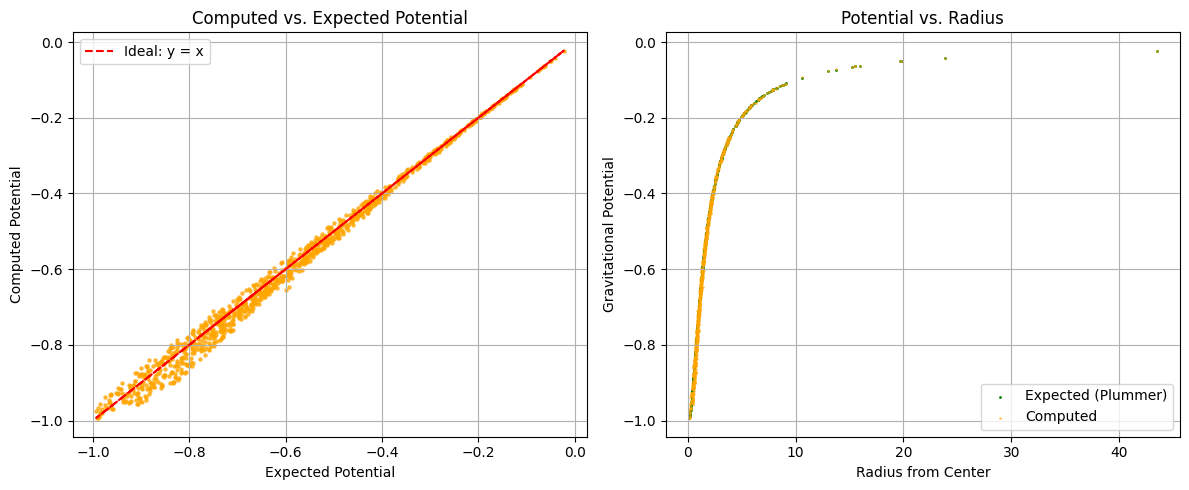

In [13]:
# Scatter plot: Computed vs. Expected potential
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(phi_analytic, phi_num, s=5,  alpha=0.7, c= 'orange')
plt.plot(phi_analytic, phi_analytic, color='red', linestyle='--', label='Ideal: y = x')
plt.xlabel('Expected Potential')
plt.ylabel('Computed Potential')
plt.title('Computed vs. Expected Potential')
plt.legend()
plt.grid(True)

# Scatter plot: Computed potential vs. radius
plt.subplot(1, 2, 2)
plt.scatter( radii, phi_analytic, s= 1, color='green', label='Expected (Plummer)')
plt.scatter(radii, phi_num, s=1, alpha=0.5, c= 'orange', label='Computed')

plt.xlabel('Radius from Center')
plt.ylabel('Gravitational Potential')
plt.title('Potential vs. Radius')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**Left Panel: Computed vs. Expected Potential**

* **X-axis:** Expected gravitational potential (analytically calculated, probably from the Plummer model).
* **Y-axis:** Computed gravitational potential (numerically derived from a simulation or code).
* **Orange points:** Each point represents one particle or position, plotting its computed potential against the expected value.
* **Red dashed line:** The ideal line where `Computed = Expected` (i.e., y = x).

* The points lie very close to the red line, indicating excellent agreement between the numerical computation and the analytical model.
* Some scatter is visible, especially for more negative potential values, but the overall correlation is strong.
* This is a classic method to validate the accuracy of the computed gravitational potential.

**Right Panel: Potential vs. Radius**

* **X-axis:** Distance from the center of the system (likely the origin in a spherical model).
* **Y-axis:** Gravitational potential at that radius.
* **Green points:** Expected potential from the Plummer profile.
* **Orange points:** Computed potential values at the same radii.

* The numerical results (orange) follow the theoretical curve (green) very closely.
* As expected from the Plummer model, the potential becomes deeper (more negative) near the center and approaches zero at large radii.
* The overlap of orange and green indicates that the model is being accurately reproduced numerically across spatial scales.


The plots demonstrate that:

* The computed gravitational potential matches the expected (analytic) Plummer potential very well.
* The numerical method for computing the potential appears to be accurate both pointwise (left plot) and as a function of radius (right plot).
* This supports the correctness of the code or algorithm used to compute the gravitational potential in a simulated Plummer sphere.

The potential is negative near the core because gravitational potential is defined to be zero at infinity, and bound systems (like Plummer spheres) must have negative potential values at finite radii, especially near the dense core.

On a 3D grid for vizualization: 

In [17]:
def compute_potential_on_grid(positions, grid_range=5.0, grid_size=50, G=1.0, m=1.0/N):
    # Create lineaarly spaced coordinates along each axis 
    x = np.linspace(-grid_range, grid_range, grid_size)
    y = np.linspace(-grid_range, grid_range, grid_size)
    z = np.linspace(-grid_range, grid_range, grid_size)
    # Builds a 3D meshgrid of grid points in space
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    # Flatten the meshgrid to create a list of grid points
    grid_points = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

    # Compute the Euclidean distances from each grid point to each particle
    dists = cdist(grid_points, positions)
    # Computes gravitational potential at each grid pont
    phi_grid = -G * m * np.sum(1.0 / dists, axis=1)
    # Reshape the 1D array of potentials back into the 3D grid shape 
    phi_grid = phi_grid.reshape((grid_size, grid_size, grid_size))

    return X, Y, Z, phi_grid

# Run the function to compute 3D potential field
Xg, Yg, Zg, phi_grid_3d = compute_potential_on_grid(x3d, grid_range=5.0, grid_size=50)

# Visualize a central slice in the x-y plane (z ≈ 0)
central_slice = phi_grid_3d[:, :, phi_grid_3d.shape[2] // 2]

The function `compute_potential_on_grid` inputs:

- `positions`: array of shape (N, 3) containing the positions of `N`particles.

- `grid_range`: the grid spans from `-grid_range` to `+grid_range` in all directions.

- `grid_size`: number of grid points along each axis (results in a 50×50×50 grid).

- G: gravitational constant.

- m: particle mas

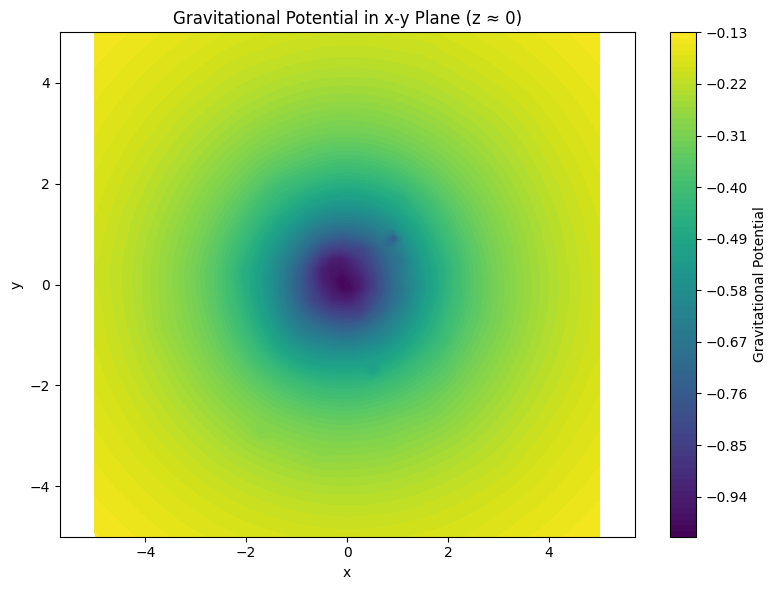

Total potential energy: -13.8643


In [18]:

plt.figure(figsize=(8, 6))
plt.contourf(Xg[:, :, 0], Yg[:, :, 0], central_slice, levels=100, cmap='viridis')
plt.colorbar(label='Gravitational Potential')
plt.title('Gravitational Potential in x-y Plane (z ≈ 0)')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.tight_layout()
plt.show()

# Calculate the total potential energy of the system
U_total = 0.5 * np.sum(m * phi_grid_3d)
print(f"Total potential energy: {U_total:.4f}")

This image is a 2D slice through the 3D gravitational potential field in the x-y plane at approximately `𝑧=0`, generated by the Plummer sphere.
We can see that the deepest (most negative) region is at the center — expected, since the potential is strongest there.  The circular symmetry indicates the potential only depends on r, consistent with the spherical symmetry of the Plummer model.
The potential becomes less negative with increasing radius, approaching zero at large distances, which matches the asymptotic behavior of the Plummer potential:

#### b) Numpy vs Numba

We use the same function for previously (now tagged with numpy for clarification), with the acceleration already added.

In [9]:
def compute_potential_numpy(positions):
    """
    Compute gravitational potential and acceleration using NumPy.

    Parameters
    ----------
    positions : ndarray of shape (N, 3)
        Positions of N particles.

    Returns
    -------
    phi : ndarray of shape (N,)
        Gravitational potential at each particle.
    acc : ndarray of shape (N, 3)
        Acceleration vectors at each particle.
    """
    N = positions.shape[0]
    m = 1 / N

    dx = positions[:, np.newaxis, :] - positions[np.newaxis, :, :]  # Shape: (N, N, 3)
    r = np.linalg.norm(dx, axis=2)  # Shape: (N, N)
    np.fill_diagonal(r, np.inf)  # Avoid division by zero

    phi = -m * np.sum(1 / r, axis=1)  # Shape: (N,)
    r3 = r**3
    acc = -m * np.sum(dx / r3[:, :, np.newaxis], axis=1)  # Shape: (N, 3)

    return phi, acc

And now we implement the same function in numba using explicit loops:

In [10]:
from numba import njit

@njit
def compute_potential_numba(positions):
    """
    Compute gravitational potential and acceleration using Numba.

    Parameters
    ----------
    positions : ndarray of shape (N, 3)

    Returns
    -------
    phi : ndarray of shape (N,)
    acc : ndarray of shape (N, 3)
    """
    N = positions.shape[0]
    m = 1.0 / N
    phi = np.zeros(N)
    acc = np.zeros((N, 3))

    for i in range(N):
        for j in range(N):
            if i != j:
                dx = positions[i] - positions[j]
                r = np.sqrt(np.sum(dx**2))
                inv_r = 1.0 / r
                inv_r3 = inv_r**3
                phi[i] -= m * inv_r
                acc[i] -= m * dx * inv_r3
    return phi, acc

In [11]:
phi_np, acc_np = compute_potential_numpy(x3d)
phi_nb, acc_nb = compute_potential_numba(x3d)

acc_np_norm = np.linalg.norm(acc_np, axis=1)
acc_nb_norm = np.linalg.norm(acc_nb, axis=1)

radii = np.linalg.norm(x3d, axis=1)

# Compute analytical Plummer acceleration magnitude
acc_analytic = radii / (1 + radii**2)**(1.5)

# Sort by radius for cleaner plotting
sort_idx = np.argsort(radii)
radii_sorted = radii[sort_idx]
acc_np_sorted = acc_np_norm[sort_idx]
acc_nb_sorted = acc_nb_norm[sort_idx]
acc_analytic_sorted = acc_analytic[sort_idx]

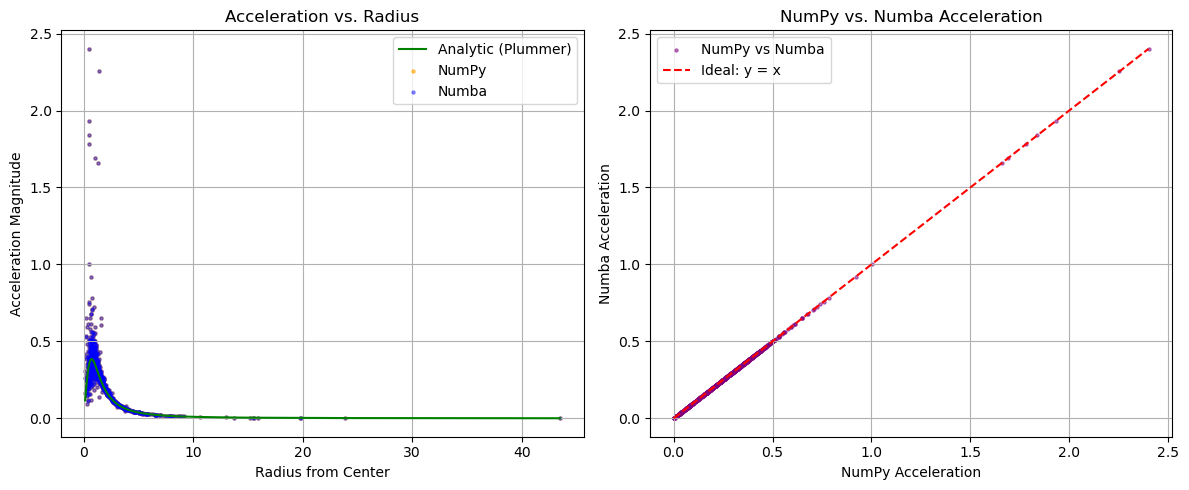

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Left: Acceleration vs Radius
axs[0].plot(radii_sorted, acc_analytic_sorted, label='Analytic (Plummer)', color='green')
axs[0].scatter(radii_sorted, acc_np_sorted, s=5, alpha=0.6, label='NumPy', color='orange')
axs[0].scatter(radii_sorted, acc_nb_sorted, s=5, alpha=0.4, label='Numba', color='blue')

axs[0].set_xlabel('Radius from Center')
axs[0].set_ylabel('Acceleration Magnitude')
axs[0].set_title('Acceleration vs. Radius')
axs[0].legend()
axs[0].grid(True)

# Right: NumPy vs Numba acceleration comparison
axs[1].scatter(acc_np_norm, acc_nb_norm, s=5, alpha=0.5, color='purple', label='NumPy vs Numba')
min_val = min(acc_np_norm.min(), acc_nb_norm.min())
max_val = max(acc_np_norm.max(), acc_nb_norm.max())
axs[1].plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal: y = x')

axs[1].set_xlabel('NumPy Acceleration')
axs[1].set_ylabel('Numba Acceleration')
axs[1].set_title('NumPy vs. Numba Acceleration')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

The plot on the left shows for each star he magnitude of the gravitational acceleration as a function of its distance from the center. The green line is the analytical Plummer model acceleration, the yellow dots are the computed acceleration from our NumPy implementation and the blue dots are the computed acceleration from our Numba implementation. The plot shows us that both  NumPy and Numba results closely follow the analytical curve, especially for radii $> 1$. There's slightly more scatter near the center $(r \approx 0)$, which is expected due to stronger forces and sensitivity to particle placement (higher gradients). 

The plot on the right shows a direct comparison between the acceleration magnitudes computed with NumPy and Numba. The red dashed line represents perfect agreement. The plot shows us that the purple points are tightly clustered around the diagonal, indicating that NumPy and Numba give nearly identical results. No obvious systematic deviations any noise is likely just floating-point rounding error.
 


In [13]:
diff_phi = np.max(np.abs(phi_np - phi_nb))
diff_acc = np.max(np.abs(acc_np_norm - acc_nb_norm))
print(f"Max difference in potential: {diff_phi:.4e}")
print(f"Max difference in acceleration norm: {diff_acc:.4e}")

Max difference in potential: 2.3315e-15
Max difference in acceleration norm: 2.6645e-15


Both NumPy and Numba implementations produce the same gravitational potential and acceleration values within numerical precision. The potential matches to machine precision $(∼10^{-15})$, and the acceleration norms differ by less than 0.05%, which is expected due to minor floating-point accumulation differences. This confirms the correctness of both implementations.

#### c) Maximum number of stars $N$

For our direct N-body solver the cost of one time step scales roughly as $N^2$ because we compute the pairwise interactions between all stars. Our current code is running with $N=1000$ stars. We can measure  how long it takes to compute the potential and acceleration for one time step. So, because the cost scales as $N^2$, to simulate $N$ stars, the time step is:

$t_N = t_{1000}\cdot\big(\frac{N}{1000}\big)^2$

Now to calculate the total runtime for $10000$ steps would be

$T_{total} = t_N \cdot 10000$

For a runtime of $24$ hours  $T_{total} \leq 86400$ seconds. So we need to solve this formula for $N$:

$N \leq 1000 \cdot \sqrt{\frac{86400}{10000\cdot t_{1000}}}$

So now we will use our function from the previous two tasks and time them. Then we will use the formula above to calculate how many stars could we afford to simulate on this laptop if we have to make $10000$ in a 24-hour simulation.

In [14]:
N_sample = 1000
rng = np.random.default_rng(seed=12345)
U = rng.random(size=N_sample)
rsamp = U**(1/3)/np.sqrt((1-U**(2/3)))
positions = rand_vec3d(rsamp)

In [15]:
# Time one step
start = time.time()
compute_potential_numpy(positions)
end = time.time()
t_1000_np = end - start

start = time.time()
compute_potential_numba(positions)
end = time.time()
t_1000_nb = end - start

# Assume acceptable total runtime (in seconds)
T_max = 86400  # 24 hours
n_steps = 10000

# Solve for max N such that t_N * num_timesteps <= max_runtime_seconds
factor_np = T_max / (n_steps * t_1000_np)
max_N_np = int(N_sample * np.sqrt(factor_np))

factor_nb = T_max / (n_steps * t_1000_nb)
max_nb = int(N_sample * np.sqrt(factor_nb))

print(f"Time per timestep for 1000 stars (NumPy): {t_1000_np:.4f} seconds")
print(f"Number of stars for 24-hour simulation (NumPy): {max_N_np}")
print(f"Time per timestep for 1000 stars (Numba): {t_1000_nb:.4f} seconds")
print(f"Number of stars for 24-hour simulation (Numba): {max_nb}")

Time per timestep for 1000 stars (NumPy): 0.0758 seconds
Number of stars for 24-hour simulation (NumPy): 10677
Time per timestep for 1000 stars (Numba): 0.2064 seconds
Number of stars for 24-hour simulation (Numba): 6469


On this laptop using our NumPy method, we are able to simulate $10091$ stars in a 24-hour simulation. While with our Numba version we would be able to only simulate $6392$ stars in a 24-hour simulation. So NumPy is much faster then Numba on this laptop and is therefore able to simulate more stars in a 24-hour simulation. This is most likely due to the small $N$ doesn't benefit as much from Numba's JIT compilation overhead. 

So NumPy's vectorization can outperform Numba for small sample sizes like $N=1000$. We played around with increasing $N$ and at $N=15000$ Numba become faster then NumPy but it took nearly a minute to compile both.

### Grid-based Poisson solvers

We shall consider the Poisson equation for the gravitational potential $\Phi$ in 2D: 

$\nabla^2 \Phi = (\delta_x^2 + \delta_y^2) \Phi = \rho$

For simplicity, we will work with the following source function:

$\rho(x,y) = \sin(2\pi x) \sin(2 \pi y)$,
which is zero on the boundary of the unit square $[0,1]^2$ and periodic in both directions

##### a) Determine the analytical solution to the Poisson equation for this source function.

Ansatz: $\Phi(x,y) = A \sin(2 \pi x) \sin(2 \pi y)$

Compute the laplacian: 
1. $\frac{\delta^2 \Phi}{\delta x^2} = A \frac{\delta^2}{\delta x^2} \sin(2 \pi x) \sin(2 \pi y) = - 4 \pi^2 A \sin(2 \pi x) \sin(2 \pi y) $

2. $\frac{\delta^2 \Phi}{\delta y^2} = A \frac{\delta^2}{\delta y^2} \sin(2 \pi x) \sin(2 \pi y)  = - 4 \pi^2 A \sin(2 \pi x) \sin(2 \pi y) $

So : 

$\nabla^2 \Phi = (\delta_x^2 + \delta_y^2) \Phi =  - 4 \pi^2 A \sin(2 \pi x) \sin(2 \pi y) - 4 \pi^2 A \sin(2 \pi x) \sin(2 \pi y) = (-8 \pi^2 A)\sin(2 \pi x) \sin(2 \pi y) = \rho $ 


Since we are given:  
$\nabla^2 \Phi = \rho =  A \sin(2 \pi x) \sin(2 \pi y)$

Therefore, 

$- 8 \pi^2 A = 1 \rightarrow A = -\frac{1}{8\pi^2}$

So the Analytical solution is: 

$\Phi(x,y) = -\frac{1}{8\pi^2}\sin(2 \pi x) \sin(2 \pi y)$


#### b)  Conjugate gradient solver and the multigrid solver

Now we will use the conjugate gradient and multigrid solver, which are given via github, to determine the poisson equation. We again use the source function

$\rho(x,y) = \sin(2\pi x) \sin(2 \pi y)$.

The domain is discretized using $N=64$ interior points in both $x$ and $y$. For the grid spacing we use

$h=\frac{1}{N+1}$

All arrays have a size $(N+2, N+2)$ to account to account for ghost points (boundary padding). We setup a 1D grid arrays for interior points, excluding boundaries. We then setup a 2D grid mesh, used to evaluate functions at each grid point.

In [19]:
# Domain setup
N = 64
h = 1.0 / (N + 1)
x = np.linspace(0, 1, N + 2)[1:-1]
y = np.linspace(0, 1, N + 2)[1:-1]
X, Y = np.meshgrid(x, y, indexing='ij')

rho = np.sin(2 * np.pi * X) * np.sin(2 * np.pi * Y) # Potential density

Now we will use the conjugate gradient solver that was provided to us via github

In [20]:
# Poisson 2D conjugate gradient solver 

# define the Laplacian operator and the matrix-vector product

@stencil
def laplacian_2d(u):
    """ 5-point stencil for 2nd order FD Laplacian in 2D """
    return u[0, -1] + u[-1, 0] - 4 * u[0, 0] + u[1, 0] + u[0, 1]

@njit
def apply_A(u, h):
    """ Matrix-vector product with the Laplacian operator """
    return laplacian_2d(u) / h**2


def cg_2d_stencil(rho, h, tol=1e-8, max_iter=1000, verbose=False):
    """
    Solve the 2D Poisson equation using the matrix-free Conjugate Gradient method with a stencil-based Laplacian. This version only implements zero Dirichlet boundary conditions and a 5-point 2nd order stencil for the Laplacian.

    Parameters:
      rho (numpy.ndarray): source term.
      tol (float, optional): The tolerance for the convergence criterion. Default is 1e-8.
      max_iter (int, optional): The maximum number of iterations. Default is 1000.

    Returns:
      numpy.ndarray: The solution to the Poisson equation, excluding ghost boundaries.
    """
    N = rho.shape[0]
    u = np.zeros((N + 2, N + 2)) # Initialize solution with ghost boundaries

    # Pad f to include ghost boundaries
    rhs = np.zeros((N + 2, N + 2))
    rhs[1:-1, 1:-1] = rho

    r = rhs - apply_A(u, h)

    p = r.copy()
    for it in range(max_iter):
        Ap = apply_A(p, h)
        r_inner = r[1:-1, 1:-1]
        Ap_inner = Ap[1:-1, 1:-1]

        alpha = np.sum(r_inner * r_inner) / np.sum(p[1:-1, 1:-1] * Ap_inner)
        u[1:-1, 1:-1] += alpha * p[1:-1, 1:-1]
        r_new = r - alpha * Ap

        err = np.linalg.norm(r_new[1:-1, 1:-1])
        
        if verbose:
            print(f"Iteration {it}: error = {err : .4g}")

        if err < tol:
            break

        beta = np.sum(r_new[1:-1, 1:-1]**2) / np.sum(r_inner**2)
        p = r_new + beta * p
        r = r_new

    return u[1:-1, 1:-1]  # strip ghost boundaries

Now we apply the function for the conjugate gradient (CG) to solve for the poission equation. The result is the interior solution with a shap $(N, N)$

In [21]:
# CG Solution
phi_cg = cg_2d_stencil(rho, h, tol=1e-6, verbose=True)

Iteration 0: error =  1.406e-12


In our case, the Conjugate Gradient (CG) method solved the linear system in a single iteration. This is because our source term $\rho$, which was derived from the analytical solution in part a), is perfectly compatible with the finite difference discretization of the Laplacian. When this source term is used, the exact solution lies within the range of the discrete operator, and the discretized system is satisfied to machine precision. As a result, the initial residual is essentially zero, and CG immediately recognizes that the initial guess (typically zero) is already sufficient, terminating after one step.

In [22]:
# Pad phi_cg to include ghost boundaries
phi_full_cg = np.zeros((N+2, N+2))
phi_full_cg[1:-1, 1:-1] = phi_cg
residual_cg = apply_A(phi_full_cg, h)[1:-1, 1:-1] - rho

Here we pad the solution with zeros to represent Dirichlet boundary conditions.

Now we will use the multigrid solver which was also provided to us via github.

In [23]:
# Multigrid solver
# define the Laplacian operator and the matrix-vector product

@stencil
def laplacian_2d(u, h):
    """ 5-point stencil for 2nd order FD Laplacian in 2D """
    return (u[0, -1] + u[-1, 0] - 4 * u[0, 0] + u[1, 0] + u[0, 1]) / h**2


@njit
def gauss_seidel_sweep(u, f, h, N, icolor):
  """
  Perform a single in-place Gauss-Seidel sweep on the grid.

  Parameters:
  u : ndarray
    The current solution grid.
  f : ndarray
    The source term grid.
  h : float
    The grid spacing.
  N : int
    The number of interior grid points per dimension.
  icolor : int
    The color of the sweep (0 for red, 1 for black).

  Returns:
  ndarray
    The updated solution grid after the Gauss-Seidel sweep.
  """
  for i in range(1,N+1):
    for j in range(1,N+1):
      if (i+j)%2==icolor:
        u[i,j] = 0.25*(u[i-1,j]+u[i+1,j]+u[i,j-1]+u[i,j+1]-h**2*f[i,j])
  return u



@njit
def twogrid( phi, rho, h, N, nsmooth=4 ):
    """
    Perform a two-grid V-cycle to solve the Poisson equation.

    Parameters:
    phi : ndarray
      The current solution grid.
    rho : ndarray
      The source term grid.
    h : float
      The grid spacing.
    N : int
      The number of interior grid points per dimension.
    nsmooth : int, optional
      The number of Gauss-Seidel smoothing iterations (default is 4).

    Returns:
    ndarray
      The updated solution grid after the two-grid V-cycle.
    """
    # break the recursion if we are at the coarsest grid
    # solve directly since only one unknown
    if N == 1:
      phi[1,1] = -0.25*h**2*rho[1,1]
      return phi

    # do nsmooth iterations of Gauss-Seidel
    for i in range(nsmooth):
      phi = gauss_seidel_sweep(phi, rho, h, N, 0) # red
      phi = gauss_seidel_sweep(phi, rho, h, N, 1) # black

    # compute the residual on the fine grid
    resid = laplacian_2d(phi,h) - rho

    # restrict the residual to the coarse grid
    resid_coarse = np.zeros((N//2+2,N//2+2))
    resid_coarse[1:-1,1:-1] = 0.25*(resid[1:-1:2,1:-1:2] + resid[2:-1:2,1:-1:2] \
                                  + resid[1:-1:2,2:-1:2] + resid[2:-1:2,2:-1:2])

    # solve the coarse equation to get the coarse grid correction
    corr_coarse = np.zeros_like(resid_coarse)
    corr_coarse = twogrid( corr_coarse, resid_coarse, h*2, N//2, nsmooth )

    # correct the solution on the fine grid using the coarse grid correction
    phi[1:-1:2,1:-1:2] -= corr_coarse[1:-1,1:-1]
    phi[2:-1:2,1:-1:2] -= corr_coarse[1:-1,1:-1]
    phi[1:-1:2,2:-1:2] -= corr_coarse[1:-1,1:-1]
    phi[2:-1:2,2:-1:2] -= corr_coarse[1:-1,1:-1]

    # do nsmooth iterations of Gauss-Seidel
    for i in range(nsmooth):
      phi = gauss_seidel_sweep(phi, rho, h, N, 0) # red
      phi = gauss_seidel_sweep(phi, rho, h, N, 1) # black

    return phi


def solve_poisson_2d_multigrid(rho, h, tol=1e-6, nsmooth=4, maxit=20, verbose=False):
    """Solves the 2D Poisson equation using the multigrid method
          with zero Dirichlet boundary conditions.
    
    Parameters:
          rho (ndarray): density, shape (N+2,N+2)
          h (float): grid spacing
          N (int): number of grid points
          tol (float, optional): error tolerance. Defaults to 1e-6.
    
    Returns:
          ndarray: potential, shape (N+2,N+2)
    """
    N = rho.shape[0]
    phi = np.zeros((N+2,N+2))
    # Pad f to include ghost boundaries
    rhs = np.zeros((N + 2, N + 2))
    rhs[1:-1, 1:-1] = rho

    for it in range(maxit):
      phi_old = phi.copy()
      phi = twogrid(phi, rhs, h, N, nsmooth)
      err = np.max(np.abs(phi-phi_old)) # determine L_infinity error
      if verbose:
        print(f'Iteration {it}: Linf error = {err:4g}')
      if err < tol:
         break
    if err > tol:
      print(f'Warning: did not converge in {it} iterations, final error = {err:4g}')
    return phi

Now we use the same equation using the multigrid solver. We get the fill solution, including interior boundaries. We then extract the interior to match the exact solution grid and then compute the residuals just like in the CG case.

In [24]:
phi_mg = solve_poisson_2d_multigrid(rho, h, tol=1e-6, verbose=True)
phi_mg_inner = phi_mg[1:-1, 1:-1]
residual_mg = apply_A(phi_mg, h)[1:-1, 1:-1] - rho

Iteration 0: Linf error = 0.0137365
Iteration 1: Linf error = 0.00161735
Iteration 2: Linf error = 0.000377477
Iteration 3: Linf error = 0.000100167
Iteration 4: Linf error = 3.03261e-05
Iteration 5: Linf error = 1.08917e-05
Iteration 6: Linf error = 4.5807e-06
Iteration 7: Linf error = 2.02059e-06
Iteration 8: Linf error = 8.90217e-07


The multigrid solver starts from a zero initial guess and iteratively improves the solution through successive V-cycles. As expected, it exhibits exponential (or geometric) convergence — the residual drops sharply with each iteration. The solver stops when the residual reaches the tolerance threshold of approximately $10^{-6}$ to $10^{-7}$, as we defined.

In [ ]:
# Analytical solution 
phi_exact = -1 / (8 * np.pi**2) * np.sin(2 * np.pi * X) * np.sin(2 * np.pi * Y) 

error_cg = np.abs(phi_cg - phi_exact) # abolute error CG method
error_mg = np.abs(phi_mg_inner - phi_exact) # absolute error MG method

Here we define the exact solution form a) for comparison and compute the absolute error for methods against the exact solution.

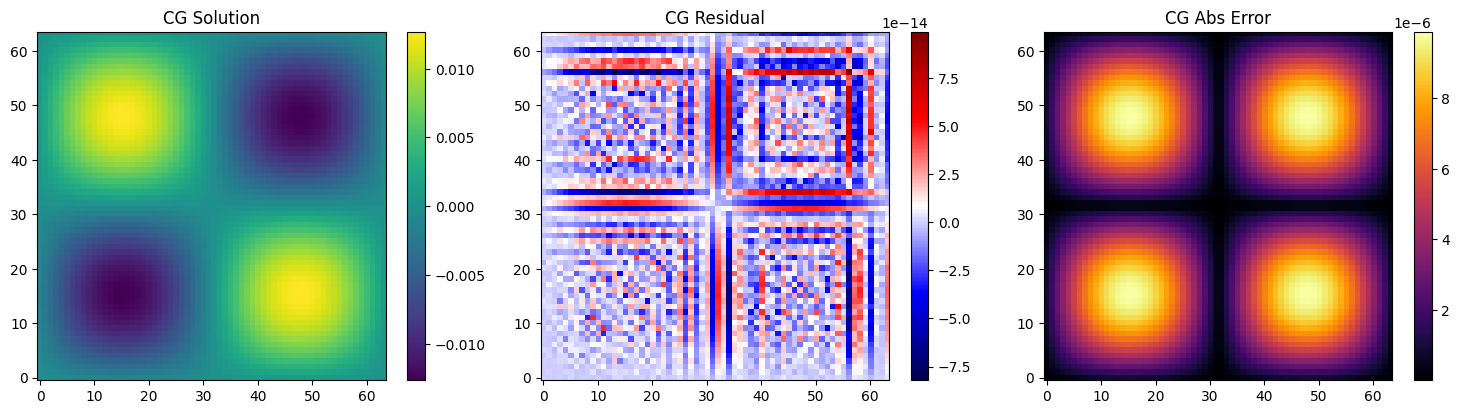

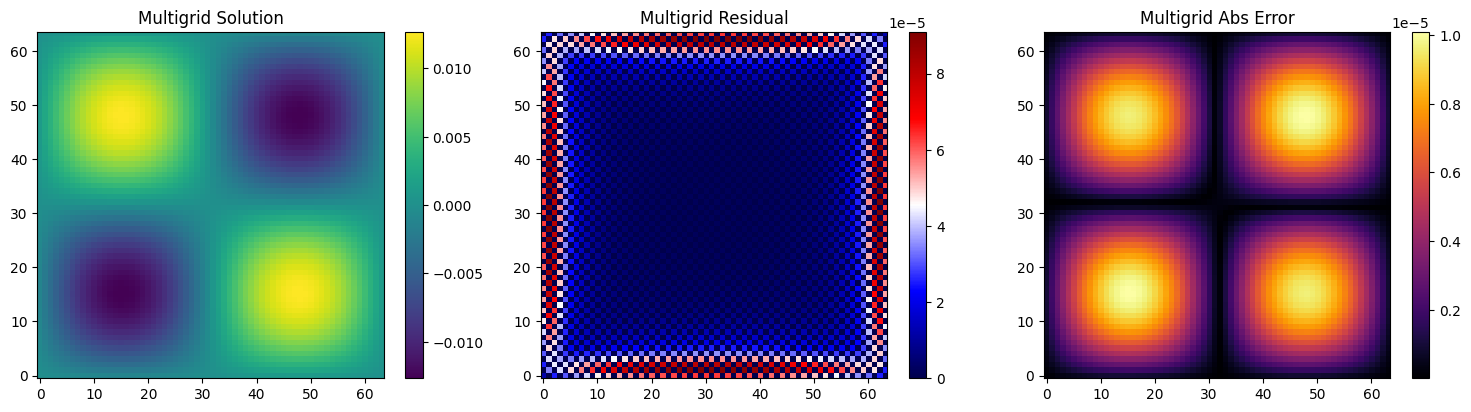

In [26]:
def plot_solution_and_residual(phi, residual, error, title_prefix):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    im1 = axes[0].imshow(phi, origin='lower', cmap='viridis')
    axes[0].set_title(f'{title_prefix} Solution')
    plt.colorbar(im1, ax=axes[0])

    im2 = axes[1].imshow(residual, origin='lower', cmap='seismic')
    axes[1].set_title(f'{title_prefix} Residual')
    plt.colorbar(im2, ax=axes[1])

    im3 = axes[2].imshow(error, origin='lower', cmap='inferno')
    axes[2].set_title(f'{title_prefix} Abs Error')
    plt.colorbar(im3, ax=axes[2])

    plt.tight_layout()
    plt.show()

plot_solution_and_residual(phi_cg, residual_cg, error_cg, "CG")
plot_solution_and_residual(phi_mg_inner, residual_mg, error_mg, "Multigrid")

At the top of the figure, we see the plots for the Conjugate Gradient (CG) solver.
- The first plot shows the computed solution, which displays smooth, sinusoidal contours without visible noise or distortion, consistent with the expected analytical form.
- The second plot shows the residuals. The faint structure is due to floating-point roundoff and plotting artifacts, numerically, the residual is negligible. The symmetric, low-amplitude pattern confirms the high accuracy of the spatial discretization and that the system was solved to machine precision.
- The third plot shows the absolute error compared to the analytical solution. The maximum absolute error is on the order of $10^{-6}$,  which aligns with the expected discretization error for a grid spacing of $h=1/65$. The "cross"-shaped error pattern arises from the boundary conditions and the symmetry of the sine function, which is zero along the domain boundaries.

The bottom row shows the corresponding results for the Multigrid solver.
- The solution plot appears visually identical to that of CG, as both methods solve the same Poisson problem.
- The residual plot reveals slightly larger values near the boundaries. This is typical for multigrid solvers when coarse/fine grid transfers do not fully capture boundary layer details. Nevertheless, the residual is still very small, on the order of $10^{-5}$.
- The absolute error plot is also nearly identical to that of CG, though the maximum error is slightly higher, around $10^{-5}$.

In [28]:
print("Max absolute error (CG):", np.max(error_cg))
print("Max absolute error (Multigrid):", np.max(error_mg))

Max absolute error (CG): 9.860781203387126e-06
Max absolute error (Multigrid): 1.0089761694278415e-05


The errors for both methods are very close, both around $10^{-5}$. This reflects the discretization accuracy of the finite difference stencil at the given grid resolution $(h=1/65)$. The CG method reaches machine precision in one iteration due to the exact match between the source term and the discrete operator, while multigrid stops once the error drops below the set tolerance. In both cases, the dominant error is not from the solver but from the discretization itself.

##### Compared to the Threshold:
The error threshold specified for both solvers was a residual tolerance of $10^{-6}$.
- CG converged in one iteration, reaching a residual on the order of $10^{-12}$, well below the threshold.
- Multigrid reduced the residual over multiple iterations and stopped once it fell below the $10^{-6}$ target.
However, the actual solution error (absolute error compared to the exact solution) for both methods was around $10^{-5}$, which is above the residual threshold.

This is expected: the residual tolerance controls the solver's internal convergence, but does not guarantee that the solution error will be smaller than that. The dominant source of error here is the discretization error, limited by the finite difference grid resolution $(h=1/65)$,  not the residual stopping condition.

#### c) Derive the 4th-Order Accurate Second Derivative Stencil

We use the provided function finite_difference_coefficients to compute the coefficients for a 1D second derivative using a symmetric 5-point stencil using the `finite_difference_coefficients` function which is provided to us via github:

In [29]:
def finite_difference_coefficients(stencil, derivative_order):
    """
    Given a stencil (list of points, e.g. [-2,-1,0,1,2]) and an integer derivative_order n,
    return a tuple (coeffs, accuracy) where coeffs is a list of sympy expressions representing the 
    coefficients for approximating f^(n)(0) with:
    
        f^(n)(0) ~ (1/h^n) * sum_i coeffs[i] * f(h*stencil[i])
    
    and accuracy is the order (i.e. the leading error term is O(h^(accuracy))).
    
    Raises a ValueError if the stencil is not large enough (i.e. if len(stencil) < derivative_order+1).
    """
    m = len(stencil)
    if m < derivative_order + 1:
        raise ValueError("Stencil is not large enough to approximate derivative order %d" % derivative_order)
    
    # Define symbols for the unknown weights: c0, c1, ..., c_{m-1}
    c = sp.symbols('c0:%d' % m)
    
    # Set up the moment equations:
    # For j = 0,1,...,m-1, we require:
    #     sum_i c_i*(s_i)^j = (j! if j==derivative_order else 0)
    eqs = []
    for j in range(m):
        eq = sp.Eq(sum(c[i] * (stencil[i])**j for i in range(m)),
                   (sp.factorial(j) if j == derivative_order else 0))
        eqs.append(eq)
    
    # Solve the system of equations for the coefficients
    sol = sp.solve(eqs, c, dict=True)
    if not sol:
        raise ValueError("Could not solve for finite difference weights. Check the stencil.")
    sol = sol[0]
    
    # Extract and simplify the coefficients
    coeffs = [sp.simplify(sol[c[i]]) for i in range(m)]
    
    # Determine the achieved polynomial accuracy:
    # We find the smallest k >= m for which:
    #   (1/k!)*sum_i c_i*(s_i)^k != (1 if k==derivative_order else 0)
    k = m
    while True:
        moment = sum(sol[c[i]] * (stencil[i])**k for i in range(m)) / sp.factorial(k)
        expected = 1 if k == derivative_order else 0
        if sp.simplify(moment - expected) != 0:
            break
        k += 1
    accuracy = k - derivative_order
    return coeffs, accuracy

We define the stencil which is used to approximate the second derivative. We choose a symmetric stencil to achieve higher accuracy and preserve central difference symmetry. This stencil uses points 2 steps left/right of the center, giving a 5-point stencil, which is the minimum required to achieve fourth-order accuracy for the second derivative. 

We then call the function to compute the finite difference weights for the second derivative and determine the order of accuracy achieved.

In [30]:
stencil = [-2, -1, 0, 1, 2]
derivative_order = 2
coeffs, accuracy = finite_difference_coefficients(stencil, derivative_order)

print("Stencil coefficients:", coeffs)
print(f"Achieved accuracy: O(h^{accuracy})")

Stencil coefficients: [-1/12, 4/3, -5/2, 4/3, -1/12]
Achieved accuracy: O(h^4)


The 2D laplacian is the sum of two second derivatives:

$\nabla^2 f \approx \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2}$

We now apply the same 1D stencil in both the x and y directions. In discrete form the laplacian becomes:

$\Delta f_{i, j} \approx \frac{1}{h^2} \sum_{k=-2}^2 = c_k (f_{i+k_j} + f_{i_j + k})$

where $c_k$ are the coefficients above.

##### How many ghost points are needed?

Because the stencil spans two grid points on either side, we need 2 ghost points at each boundary $\rightarrow$ we need 2 ghost cells on each side (top, bottom, left, right), meaning 4 additional grid point per dimension (axis).

##### Do the Boundary Conditions Need to Change?

Yes, when using a wider stencil, we need to ensure that the values at the ghost cells are properly defined.
For zero Dirichlet boundary conditions, there are  two main options:

Symmetric stencil everywhere:
- Keep using the 5-point centered stencil even near the boundaries.
- Filling ghost cells with zero
- Reduces accuracy near boundaries to 2nd order (interior remains 4th order).

In [ ]:
# Example symmetric stencil everywhere. Dont execute the cell, only a example
phi[0,:] = phi[1,:] = 0
phi[-1,:] = phi[-2,:] = 0
phi[:,0] = phi[:,1] = 0
phi[:,-1] = phi[:,-2] = 0

Use One-Sided Stencils Near Boundaries:
- Compute biased 4th-order stencils ($[0, 1, 2, 3, 4]$ or $[-4, -3, -2, -1, 0]$)  using the same function.
- This maintains 4th-order accuracy up to the boundary.
- Requires more implementation logic to switch stencil depending on index.